https://towardsdatascience.com/human-like-machine-hearing-with-ai-2-3-f9fab903b20a
Ideas for possibly having a lower resolution window of other parts of the song in addition to the actual input? Instead of what was listed here, how about having a window in both directions instead?

In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy import array
import librosa
import librosa.display
import requests
import json
import logging
import os
from os import path
from io import BytesIO
import zipfile
import shutil
import glob
import math
import matplotlib.pyplot as plt

# Keras imports
import keras
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge, Input
from keras.layers.core import *

# Sci-kit learn imports for pre-processing
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
model_run_name = "test3"
spec_win_len = 1
num_mels = 80
rounding_win_len = 10

# These are the keys that are top rated as of the original run of this notebook
#train_keys = ["570", "124", "1bf", "217", "e4", "3fc"] # 15 maps
#test_keys = ["141", "32e"] # 5 maps

train_keys = ['570', '141', '124', '1bf', '32e', '217', 'e4', '3fc', '462',
       '1f90', '1ef', '1fef', '155', '13e9', '3cf5', '480', '4c6', 'b',
       '636', '45e', '133b', 'c5', '9', '21', '1a8a', '348', 'bd3', '25f',
       '2144', '3a4', '1ffd', '21c', '78e', '121f', 'efe', '3700', '26f6']

In [3]:
song_df = pd.read_csv("./Data/MetadataNew.csv")
song_df = song_df.sort_values("net_votes", ascending=False)
song_df.head(100)

,Unnamed: 0,key,level_author_name,song_name,song_sub_name,upvotes,downvotes,plays,upload_date,downloads,bpm,net_votes,percent_upvotes,filename,song_length,difficulty,map_filename
1996,0,570,greatyazer,Mr. Blue Sky,Electric Light Orchestra,6092.0,120.0,39426.0,2018-06-16T16:53:34.000Z,342795.0,174.0,5972.0,0.980683,song.egg,222.197551,Expert,Expert.dat
1994,0,570,greatyazer,Mr. Blue Sky,Electric Light Orchestra,6092.0,120.0,39426.0,2018-06-16T16:53:34.000Z,342795.0,174.0,5972.0,0.980683,song.egg,222.197551,Normal,Normal.dat
1995,0,570,greatyazer,Mr. Blue Sky,Electric Light Orchestra,6092.0,120.0,39426.0,2018-06-16T16:53:34.000Z,342795.0,174.0,5972.0,0.980683,song.egg,222.197551,Hard,Hard.dat
417,0,141,greatyazer,Gangnam Style,PSY,6164.0,225.0,82700.0,2018-05-20T09:59:02.000Z,520342.0,132.0,5939.0,0.964783,song.egg,218.824187,Normal,Normal.dat
418,0,141,greatyazer,Gangnam Style,PSY,6164.0,225.0,82700.0,2018-05-20T09:59:02.000Z,520342.0,132.0,5939.0,0.964783,song.egg,218.824187,Hard,Hard.dat
419,0,141,greatyazer,Gangnam Style,PSY,6164.0,225.0,82700.0,2018-05-20T09:59:02.000Z,520342.0,132.0,5939.0,0.964783,song.egg,218.824187,Expert,Expert.dat
377,0,124,jobas,Rasputin (Funk Overload),NaN,6253.0,318.0,29624.0,2018-05-19T16:36:34.000Z,406245.0,149.0,5935.0,0.951606,song.egg,238.524082,Hard,Hard.dat
596,0,1bf,calijor,Lone Digger,NaN,5569.0,287.0,57999.0,2018-05-23T00:15:19.000Z,356627.0,124.0,5282.0,0.950990,Caravan Palace - Lone Digger.egg,169.926531,Expert,Expert.dat
595,0,1bf,calijor,Lone Digger,NaN,5569.0,287.0,57999.0,2018-05-23T00:15:19.000Z,356627.0,124.0,5282.0,0.950990,Caravan Palace - Lone Digger.egg,169.926531,Hard,Hard.dat
594,0,1bf,calijor,Lone Digger,NaN,5569.0,287.0,57999.0,2018-05-23T00:15:19.000Z,356627.0,124.0,5282.0,0.950990,Caravan Palace - Lone Digger.egg,169.926531,Normal,Normal.dat


The following is used to download any songs from the BeatSaber Community Site. This is similar to the download done in the beatmap data analysis, but it grabs only the information needed and also grabs the filename for song files that differ from the expected DifficultName.dat filename scheme

In [4]:
def create_song_dict():
    song_dict = {}
    song_dict["time"] = []
    song_dict["type"] = []
    song_dict["value"] = []
    song_dict["line_index"] = []
    song_dict["line_layer"] = []
    song_dict["cut_direction"] = []
    song_dict["duration"] = []
    song_dict["width"] = []
    song_dict["object_type"] = []
    
    return song_dict

def add_event_to_dict(song_dict, time, event_type, value):
    """Appends the values for an event to the song's dictionary"""
    song_dict["time"].append(time)
    song_dict["type"].append(event_type)
    song_dict["value"].append(value)
    song_dict["line_index"].append(np.nan) # NA on events
    song_dict["line_layer"].append(np.nan) # NA on events
    song_dict["cut_direction"].append(np.nan) # NA on events
    song_dict["duration"].append(np.nan) # NA on events
    song_dict["width"].append(np.nan) # NA on events
    song_dict["object_type"].append("Event")

    
def add_note_to_dict(song_dict, time, line_index, line_layer, note_type, cut_direction):
    """Appends the values for a note (which includes bombs) to the song's dictionary"""
    song_dict["time"].append(time)
    song_dict["type"].append(note_type)
    song_dict["value"].append(np.nan) # NA on notes/bombs
    song_dict["line_index"].append(line_index)
    song_dict["line_layer"].append(line_layer)
    song_dict["cut_direction"].append(cut_direction)
    song_dict["duration"].append(np.nan) # NA on notes/bombs
    song_dict["width"].append(np.nan) # NA on notes/bombs
    
    if (note_type == 1) or (note_type == 0):
        song_dict["object_type"].append("Note")
    else:
        song_dict["object_type"].append("Bomb")

        
def add_obstacle_to_dict(song_dict, time, line_index, obstacle_type, duration, width):
    """Appends the values for an obstacle to the song's dictionary"""
    song_dict["time"].append(time)
    song_dict["type"].append(obstacle_type)
    song_dict["value"].append(np.nan)
    song_dict["line_index"].append(line_index) # NA on obstacles
    song_dict["line_layer"].append(np.nan) # NA on obstacles
    song_dict["cut_direction"].append(np.nan) # NA on obstacles
    song_dict["duration"].append(duration) # NA on obstacles
    song_dict["width"].append(width) # NA on obstacles
    song_dict["object_type"].append("Obstacle")

    
def get_pandas_song_map(row):
    """Get the pandas dataframe for a map file, or convert the song map file into a pandas representation"""
    
    orig_filename = "data/{}/{}".format(row["key"], row["map_filename"])
    new_filename = orig_filename.replace(".dat", "Pandas.json")
    
    if path.exists(new_filename):
        df = pd.read_json(new_filename)
    else:
        with open(orig_filename) as temp_json:
            temp_data = json.load(temp_json)
            temp_dict = create_song_dict()

            # Get all notes
            for note in temp_data["_notes"]:
                add_note_to_dict(temp_dict, note["_time"] * 60 / row["bpm"], note["_lineIndex"], note["_lineLayer"], 
                                 note["_type"], note["_cutDirection"])

            for event in temp_data["_events"]:
                add_event_to_dict(temp_dict, event["_time"] * 60 / row["bpm"], event["_type"], event["_value"])

            for obstacle in temp_data["_obstacles"]:
                add_obstacle_to_dict(temp_dict, obstacle["_time"] * 60 / row["bpm"], obstacle["_lineIndex"], obstacle["_type"],
                                    obstacle["_duration"], obstacle["_width"])

        # OUT OF SCOPE FOR THIS PROJECT FOR NOW
        #for bpm_change in temp_data["_BPMChanges"]
        df = pd.DataFrame(temp_dict)
        df["object_type"] = df["object_type"].astype('category')
        df.to_json(new_filename)
    return df

In [5]:
def download_song_with_key(key):
    try:
        new_song_df = get_single_song_metadata_df(key) # info from beatsaver
        download_song(key) # actual files from beatsaver
        new_song_df = get_song_info_from_local_files(new_song_df) # metadata that can only be found from local files
        new_song_df.apply(get_pandas_song_map, axis=1)
        
        return new_song_df
    except Exception as e:
        logger.warning("Couldn't download song for key: " + key + ", error is: " + str(e))
        empty_dict = {}
        empty_dict["key"] = [key]
        return pd.DataFrame(empty_dict)
    

def get_song_info_from_local_files(song_df):
    # Open the info.dat file which contains local metadata
    with open('./Data/{}/info.dat'.format(song_df.iloc[0]["key"]), errors="ignore", encoding="utf-8") as json_file:
        # Convert to JSON and grab the filename of the song
        data = json.load(json_file)
        song_df["filename"] = data["_songFilename"]
        
        # Get song length via librosa
        song_df["song_length"] = librosa.get_duration(filename="./Data/{}/{}".format(song_df.iloc[0]["key"], 
                                                                                         song_df.iloc[0]["filename"]))
        first_difficulty = True
        copy_df = song_df.copy()
        
        # Iterate through all types of maps
        for i in range(len(data["_difficultyBeatmapSets"])):
            beat_map_set = data["_difficultyBeatmapSets"][i]
            
            # We can only use standard, so make sure we have the standard map
            if beat_map_set["_beatmapCharacteristicName"] == "Standard":
                # Iterate through all different difficulties listed and grab their associated filename
                for j in range(len(beat_map_set["_difficultyBeatmaps"])):
                    dif_beat_map = beat_map_set["_difficultyBeatmaps"][j]
                    
                    if first_difficulty == True:
                        first_difficulty = False
                        song_df["difficulty"] = dif_beat_map["_difficulty"]
                        song_df["map_filename"] = dif_beat_map["_beatmapFilename"]
                    else:
                        copy_df["difficulty"] = dif_beat_map["_difficulty"]
                        copy_df["map_filename"] = dif_beat_map["_beatmapFilename"]
                        song_df = pd.concat([song_df, copy_df])
        
    return song_df
        
                                    
def get_single_song_metadata_df(data_key):
    """Retrieves the metadata info for a single song"""
    ratings_data = {}
    # Basic counts for upvotes, downvotes, and downloads and the download URL
    data = requests.get("https://beatsaver.com/api/maps/detail/{}".format(data_key)).json()
    
    logging.debug(data)
    
    ratings_data["key"] = [data_key]
    ratings_data["level_author_name"] = [data["metadata"]["levelAuthorName"]]
    ratings_data["song_name"] = [data["metadata"]["songName"]]
    ratings_data["song_sub_name"] = [data["metadata"]["songSubName"]]
    ratings_data["upvotes"] = [data["stats"]["upVotes"]]
    ratings_data["downvotes"] = [data["stats"]["downVotes"]]
    ratings_data["plays"] = [data["stats"]["plays"]]
    ratings_data["upload_date"] = [data["uploaded"]]
    ratings_data["downloads"] = [data["stats"]["downloads"]]
    ratings_data["bpm"] = [data["metadata"]["bpm"]]
    
    logging.info(ratings_data)
    song_df = pd.DataFrame.from_dict(ratings_data)
    song_df["net_votes"] = song_df["upvotes"] - song_df["downvotes"]
    song_df["percent_upvotes"] = 0
    
    if song_df.iloc[0]["upvotes"] != 0:
        song_df["percent_upvotes"] = song_df["upvotes"] / (song_df["upvotes"] + song_df["downvotes"])
    
    return song_df
    

def create_dir(key):
    """Creates a folder for the passed in key if one does not already exist. Returns the directory name"""
    directory = "./Data/{}".format(key)
    if not os.path.exists(directory):
        logging.debug("Path for " + key + " didn't already exist. Creating")
        os.makedirs(directory)
    return directory


def download_song(key):
    """Perform the actual song download"""
    directory = create_dir(key)

    if already_downloaded(key):
        logging.info("Songs already downloaded for key " + key)
    else:
        # Get the metadata and the song download link from the metadata
        song_zip = requests.get("https://beatsaver.com/api/download/key/{}".format(key), stream=True)
        os.chdir(directory)

        if song_zip.ok:
            # Extract to a zip file
            z = zipfile.ZipFile(BytesIO(song_zip.content))
            z.extractall()

            file_list = os.listdir(".")
            for file in file_list:
                # Clean up non-data files like cover, and random lightmap.exe
                if not file.endswith(".dat") and not file.endswith(".egg") and not file.endswith(".ogg"):
                    # There are also occasionally folders that are created. We don't need those either
                    if os.path.isfile(file):
                        os.remove(file)
                    else:
                        shutil.rmtree(file)
        else:
            logging.warning("Could not get files for key {}. Response code {}".format(key, song_zip.status_code))
            # Create a file in the folder showing that this key is invalid
            open("invalid.txt", "a").close()

        os.chdir("../..")


def already_downloaded(key):
    """Check if the song file has already been downloaded. Return true if it has"""
    lookup1 = "./Data/{}/*.egg".format(key)
    lookup2 = "./Data/{}/*.ogg".format(key)
    lookup3 = "./Data/{}/invalid.txt".format(key)
    return len(glob.glob(lookup1)) > 0 or len(glob.glob(lookup2)) > 0 or len(glob.glob(lookup3)) > 0

In [6]:
#%%time
# COMMENTED OUT SINCE THE FOLLOWING TOOK 4h 9min 51s to run for 25657 keys (with a lot of songs already downloaded)
# IF YOU RUN THE FOLLOWING IT WILL DOWNLOAD *ALL* BEATSABER SONGS ON THE COMMUNITY SITE
#logger = logging.getLogger()
#logger.setLevel(logging.CRITICAL)
#song_df = pd.DataFrame()

#max_key = int(requests.get("https://beatsaver.com/api/maps/latest/0").json()["docs"][0]["key"], 16)

# Get all hex keys
#for i in range(max_key):
#    new_song_df = download_song_with_key(hex(i)[2:])
#    song_df = pd.concat([song_df, new_song_df], sort=False)
    
#    if i % 100 == 0:
#        print("Downloaded {} Keys".format(i))

#song_df.to_csv("data/MetadataNew.csv")

Now that we have as many songs as we want, it is time to decide on a subset of songs to use for this

In [7]:
sample_keys = song_df.head(100).key.unique()
sample_keys

array(['570', '141', '124', '1bf', '32e', '217', 'e4', '3fc', '462',
       '1f90', '1ef', '1fef', '155', '13e9', '3cf5', '480', '4c6', 'b',
       '636', '45e', '133b', 'c5', '9', '21', '1a8a', '348', 'bd3', '25f',
       '2144', '3a4', '1ffd', '21c', '78e', '121f', 'efe', '3700', '26f6',
       '3a', '5fc', '24e'], dtype=object)

So we now have the keys that we want to use, but we need some actual data to train on. 

For training we are going to have 2 steps. The first step (which is started below) is to train a neural network on how to determine where to place notes, bombs, obstacles, and events in the song (without classifying the position or any classification problems about the objects themselves).

To do that the approach is as follows:
1. Create spectrograms of the song in a set size of chunks (e.g. 1 second chunks) so that we can have a constant input length (with the end of the song padded with 0s)
2. Get the count of each object type at each timestep (e.g. count how many notes occur at each 10 milisecond spot)
3. Use the spectrograms as the training data and the object counts as the "labels" for the neural net

In [8]:
def get_spectrograms(song_df, key, win_len, num_mels, rounding_win_len):
    """Get the spectrograms of the song with the specified window length and number of mels"""
    
    # See if we already have the melspectrogram created since that can take a bit
    spec_filename = "data/{}/{}-{}melspec.npy".format(key, num_mels, rounding_win_len)
    
    if path.exists(spec_filename):
        spec = np.load(spec_filename)
    else:
        # Get the name of file that will have the actual song data (e.g. song.ogg)
        filename = "data/{}/{}".format(key, song_df[song_df.key == key].iloc[0]["filename"])

        # Create the spectrogram and save to a file
        y, sr = librosa.load(filename)
        spec = librosa.feature.melspectrogram(y=y, sr=sr, 
                                              hop_length=math.ceil(rounding_win_len / 1000 * sr), 
                                              n_mels=num_mels, fmin=20, fmax=8000)
        np.save(spec_filename, spec)
    
    # Determine how many windows of "win_len" size we should have
    #import pdb; pdb.set_trace()
    frames_per_win = win_len * 1000 / rounding_win_len
    num_windows = int(math.ceil(song_df[song_df.key == key].iloc[0]["song_length"]) / win_len)
    
    # Pad it out to be evenly divisible
    spec = np.pad(spec, [(0, 0), (0, int(num_windows * frames_per_win - spec.shape[1]))], 'constant', constant_values=0)
    
    
    # Split the array into "num_windows" arrays
    logging.debug("Spec shape before split: {}".format(spec.shape));
    spec_split = np.split(spec, num_windows, axis=1)
    
    logging.debug("Spec split shape: {} by {}".format(len(spec_split), spec_split[0].shape));
    
    spec_combine = array(spec_split)
    logging.debug("Spec combine shape: {}".format(spec_combine.shape));
    
    return spec_combine

In [9]:
def get_onsets(song_df, key, win_len, num_mels, rounding_win_len):
    """Get the spectrograms of the song with the specified window length and number of mels"""
    
    
    # Get the name of file that will have the actual song data (e.g. song.ogg)
    filename = "data/{}/{}".format(key, song_df[song_df.key == key].iloc[0]["filename"])

    # Create the spectrogram and save to a file
    y, sr = librosa.load(filename)
    
    # Determine how many windows of "win_len" size we should have
    song_len = song_df[song_df.key == key].iloc[0]["song_length"]
    num_windows = math.ceil(song_len / win_len)
    frames_per_win = int(win_len * 1000 / rounding_win_len)
    
    # Get the onsets for the file and load them into the array
    onsets = librosa.onset.onset_detect(y, units="time")
    onset_arr = np.zeros(num_windows * frames_per_win)
    
    for onset in onsets:
        onset_arr[int(round(onset * 1000 / rounding_win_len))] = 1
    
    split_arr = array(np.split(onset_arr, num_windows))
    
    return split_arr

In [10]:
def set_onset_count_arr_from_df(df, cur_input_num, num_counts_per_win, object_type, arr):
    """Reads the data from the dataframe and adds it to the passed in numpy arr"""
    
    # Gets the current window that we are curious about
    temp_df = df[(df.object_type == object_type) 
                 & (df.input_num >= cur_input_num) 
                 & (df.input_num < cur_input_num + num_counts_per_win)]
    
    # Iterates through the dataframe slice and puts the counts into the appropriate index of the array
    for index, row in temp_df.iterrows():
        arr[int(row["input_num"] - cur_input_num)] = row["time"]
        

def get_onset_counts(song_df, key, difficulty, spec_win_len, rounding_win_len, num_samples):
    #import pdb; pdb.set_trace()
    # Get the filename and read it into a pandas dataframe
    obj_df = get_pandas_song_map(song_df[(song_df.key == key) & (song_df.difficulty == difficulty)].iloc[0])
    logging.debug("obj_df before: {}".format(obj_df.sort_values("time")))
    
    # Get the number of objects that occur at each timeframe
    obj_df["input_num"] = round(obj_df["time"] * 1000 / rounding_win_len)
    obj_df = obj_df.sort_values("input_num").groupby(["input_num", "object_type"])["time"].count().to_frame().reset_index()
    logging.debug("obj_df after: {}".format(obj_df))
    
    # Get the number of counts that will be available per window
    num_counts_per_win = int(spec_win_len * 1000 / rounding_win_len)
    logging.debug("Number of counts per window is {}".format(num_counts_per_win))
    
    cur_input_num = 0
    

    notes_list = []
    bombs_list = []
    obstacles_list = []
    events_list = []

    for x in range(num_samples):
        logging.debug("Checking input num {} through {}".format(cur_input_num, cur_input_num + num_counts_per_win - 1))
        # Initialize arrays to 0
        notes_arr = np.zeros(num_counts_per_win)
        bombs_arr = np.zeros(num_counts_per_win)
        obstacles_arr = np.zeros(num_counts_per_win)
        events_arr = np.zeros(num_counts_per_win)
        
        # This essentially transposes the dataframe and then adds puts the appropriate values into the numpy array
        set_onset_count_arr_from_df(obj_df, cur_input_num, num_counts_per_win, "Note", notes_arr)
        set_onset_count_arr_from_df(obj_df, cur_input_num, num_counts_per_win, "Bomb", bombs_arr)
        set_onset_count_arr_from_df(obj_df, cur_input_num, num_counts_per_win, "Obstacle", obstacles_arr)
        set_onset_count_arr_from_df(obj_df, cur_input_num, num_counts_per_win, "Event", events_arr)
        
        # Add each of the arrays to the list
        notes_list.append(notes_arr)
        bombs_list.append(bombs_arr)
        obstacles_list.append(obstacles_arr)
        events_list.append(events_arr)

        # Go to next window
        cur_input_num += num_counts_per_win

    # Convert from lists of numpy arrays to a 2D numpy array
    note_data = np.vstack(notes_list)
    bomb_data = np.vstack(bombs_list)
    obstacle_data = np.vstack(obstacles_list)
    event_data = np.vstack(events_list)
    
    return note_data, bomb_data, obstacle_data, event_data

In [11]:
def get_song_count_train_data(song_df, key, spec_win_len, num_mels, rounding_win_len, difficulties="all"):
    """Get lists of numpy arrays for a song with the training data and the counts (aka labels)"""
    
    # Get all spectrogram values for the song
    specs = get_spectrograms(song_df, key, spec_win_len, num_mels, rounding_win_len)
    
    # Get all onsets predicted by Librosa
    onsets = get_onsets(song_df, key, spec_win_len, num_mels, rounding_win_len)
    
    # The timestamp of the spec is an additional feature that we care about alongside the spectrogram
    #time_range = np.arange(0, specs.shape[0], 1) * spec_win_len
    #time_range = time_range.reshape(time_range.shape[0], 1)
    
    # Create the lists that will hold our numpy arrays for the different difficulties
    other_list = []
    spec_list = []
    note_list = []
    bomb_list = []
    obst_list = []
    event_list = []
    
    # Get the difficulties available for the song and iterate over them
    if difficulties == "all":
        difficulties = song_df[song_df.key == key]["difficulty"]
    
    for difficulty in difficulties:
        # Get the difficulty as an integer. This is a category but we are NOT using one-hot encoding as
        # "Expert" is more like "ExpertPlus" than "Easy" so a numerical category is fine here
        if difficulty == "Easy":
            dif_val = 1
        elif difficulty == "Normal":
            dif_val = 2
        elif difficulty == "Hard":
            dif_val = 3
        elif difficulty == "Expert":
            dif_val = 4
        elif difficulty == "ExpertPlus":
            dif_val = 5
        else:
            dif_val = 0 # Error condition as we don't recognize this difficulty type
            
        if dif_val != 0:
            # The difficulty is another feature that we care about, so include it alongside as well
            #import pdb; pdb.set_trace()
            dif_ray = np.ones((specs.shape[0], 1)) * dif_val
            dif_ray = dif_ray.reshape(dif_ray.shape[0], 1)
            other_ray = np.hstack([onsets, dif_ray])
            other_list.append(other_ray)
            
            #import pdb; pdb.set_trace()
            spec_list.append(specs.copy())
            
            # Get the counts at each point for all objects
            notes, bombs, obsts, events = get_onset_counts(song_df, key, difficulty, spec_win_len, rounding_win_len, specs.shape[0])
            
            logging.info("Shapes are notes: {}, obsts: {}, bombs: {}, events:{}".format(notes.shape, obsts.shape, bombs.shape, events.shape))
            
            note_list.append(notes)
            bomb_list.append(bombs)
            obst_list.append(obsts)
            event_list.append(events)
    
    return other_list, spec_list, note_list, bomb_list, obst_list, event_list

In [12]:
def get_count_train_data_for_keys(song_df, keys, spec_win_len, num_mels, rounding_win_len, difficulties="all"):
    other_list = []
    spec_list = []
    note_list = []
    bomb_list = []
    obst_list = []
    event_list = []
    
    for key in keys:
        download_song_with_key(key)
        
        other, specs, notes, bombs, obsts, events = get_song_count_train_data(song_df, key, spec_win_len, num_mels, rounding_win_len, difficulties)
        other_list.extend(other)
        spec_list.extend(specs)
        note_list.extend(notes)
        bomb_list.extend(bombs)
        obst_list.extend(obsts)
        event_list.extend(events)
    
    other_arr = np.vstack(other_list)
    spec_arr = np.vstack(spec_list)
    note_arr = np.vstack(note_list)
    bomb_arr = np.vstack(bomb_list)
    obst_arr = np.vstack(obst_list)
    event_arr = np.vstack(event_list)
    
    return other_arr, spec_arr, note_arr, bomb_arr, obst_arr, event_arr

Creating the test files for the first run. You can skip this section if you wish as the files are already uploaded

In [13]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
directory = "./ModelRuns/{}".format(model_run_name)
if not os.path.exists(directory):
    os.makedirs(directory)

train_other, train_spec, train_note, train_bomb, train_obst, train_event = get_count_train_data_for_keys(song_df, train_keys, spec_win_len, num_mels, rounding_win_len)

I1019 11:51:41.768827  7736 <ipython-input-5-0c6724d3e65b>:70] {'key': ['570'], 'level_author_name': ['greatyazer'], 'song_name': ['Mr. Blue Sky'], 'song_sub_name': ['Electric Light Orchestra'], 'upvotes': [6763], 'downvotes': [134], 'plays': [39426], 'upload_date': ['2018-06-16T16:53:34.000Z'], 'downloads': [366211], 'bpm': [174]}
I1019 11:51:41.775824  7736 <ipython-input-5-0c6724d3e65b>:95] Songs already downloaded for key 570
I1019 11:51:51.159476  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (223, 100), obsts: (223, 100), bombs: (223, 100), events:(223, 100)
I1019 11:51:52.615645  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (223, 100), obsts: (223, 100), bombs: (223, 100), events:(223, 100)
I1019 11:51:54.089803  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (223, 100), obsts: (223, 100), bombs: (223, 100), events:(223, 100)
I1019 11:51:54.331853  7736 <ipython-input-5-0c6724d3e65b>:70] {'key': ['141'], 'level_author_name': ['greatyazer'],

I1019 11:54:02.000409  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (202, 100), obsts: (202, 100), bombs: (202, 100), events:(202, 100)
I1019 11:54:03.338645  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (202, 100), obsts: (202, 100), bombs: (202, 100), events:(202, 100)
I1019 11:54:04.724853  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (202, 100), obsts: (202, 100), bombs: (202, 100), events:(202, 100)
I1019 11:54:05.599879  7736 <ipython-input-5-0c6724d3e65b>:70] {'key': ['1fef'], 'level_author_name': ['rustic'], 'song_name': ['Believer (100k ver.)'], 'song_sub_name': ['Imagine Dragons'], 'upvotes': [3346], 'downvotes': [49], 'plays': [9381], 'upload_date': ['2018-11-12T17:53:58.000Z'], 'downloads': [200389], 'bpm': [125]}
I1019 11:54:05.603868  7736 <ipython-input-5-0c6724d3e65b>:95] Songs already downloaded for key 1fef
I1019 11:54:15.343581  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (206, 100), obsts: (206, 100), bombs: (

I1019 11:57:30.353948  7736 <ipython-input-5-0c6724d3e65b>:95] Songs already downloaded for key c5
I1019 11:57:42.959042  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (159, 100), obsts: (159, 100), bombs: (159, 100), events:(159, 100)
I1019 11:57:43.192994  7736 <ipython-input-5-0c6724d3e65b>:70] {'key': ['9'], 'level_author_name': ['jackscape'], 'song_name': ['Take On Me'], 'song_sub_name': [''], 'upvotes': [2758], 'downvotes': [224], 'plays': [36801], 'upload_date': ['2018-05-08T17:44:17.000Z'], 'downloads': [484675], 'bpm': [168]}
I1019 11:57:43.197000  7736 <ipython-input-5-0c6724d3e65b>:95] Songs already downloaded for key 9
I1019 11:57:54.515644  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (140, 100), obsts: (140, 100), bombs: (140, 100), events:(140, 100)
I1019 11:57:54.764069  7736 <ipython-input-5-0c6724d3e65b>:70] {'key': ['21'], 'level_author_name': ['datkami'], 'song_name': ['LUVORATORRRRRY!'], 'song_sub_name': ['feat.nqrse'], 'upvotes': [2541],

I1019 12:00:53.013793  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (154, 100), obsts: (154, 100), bombs: (154, 100), events:(154, 100)
I1019 12:00:54.158501  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (154, 100), obsts: (154, 100), bombs: (154, 100), events:(154, 100)
I1019 12:00:55.225892  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (154, 100), obsts: (154, 100), bombs: (154, 100), events:(154, 100)
I1019 12:00:55.461297  7736 <ipython-input-5-0c6724d3e65b>:70] {'key': ['78e'], 'level_author_name': ['downycat'], 'song_name': ['Numb'], 'song_sub_name': ['Linkin Park'], 'upvotes': [2292], 'downvotes': [97], 'plays': [16454], 'upload_date': ['2018-07-02T13:44:43.000Z'], 'downloads': [177596], 'bpm': [110]}
I1019 12:00:55.511274  7736 <ipython-input-5-0c6724d3e65b>:95] Songs already downloaded for key 78e
I1019 12:01:11.780108  7736 <ipython-input-11-c1a6d8e4e86f>:56] Shapes are notes: (188, 100), obsts: (188, 100), bombs: (188, 100), events:(

In [14]:
print(train_other.shape)
print(train_spec.shape)
print(train_note.shape)
print(train_bomb.shape)
print(train_obst.shape)
print(train_event.shape)

(18336, 101)
(18336, 80, 100)
(18336, 100)
(18336, 100)
(18336, 100)
(18336, 100)


In [15]:
np.save("{}/train_other".format(directory), train_other)
np.save("{}/train_spec".format(directory), train_spec)
np.save("{}/train_note".format(directory), train_note)
np.save("{}/train_bomb".format(directory), train_bomb)
np.save("{}/train_obst".format(directory), train_obst)
np.save("{}/train_event".format(directory), train_event)

Keras model

In [16]:
# Load data back in
directory = "./ModelRuns/{}".format(model_run_name)
train_spec = np.load("{}/train_spec.npy".format(directory))
train_other = np.load("{}/train_other.npy".format(directory))
train_note = np.load("{}/train_note.npy".format(directory))

In [17]:
train_note = np.ceil(train_note / 100)

In [18]:
# Standardize code from 
# https://github.com/slychief/ismir2018_tutorial/blob/master/Part_1_Convolutional_Neural_Networks.ipynb
def standardize(data):
    # vectorize before standardization (cause scaler can't do it in that format)
    N, ydim, xdim = data.shape
    data = data.reshape(N, xdim*ydim)

    # standardize
    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    # reshape to original shape
    return data.reshape(N, ydim, xdim, 1) # Add extra 1 for convnet as it expects a 4th dimension for channels

In [19]:
def resize_specs(spec_arr):
    if spec_arr.ndim == 3:
        N, ydim, xdim = spec_arr.shape
        return spec_arr.reshape(N, ydim, xdim, 1)
    elif spec_arr.ndim == 4:
        return spec_arr
    else:
        raise Exception("Spec array has {} dimensions instead of 3 or 4".format(spec_arr.ndim))


In [20]:
#train_spec = standardize(train_spec)
#test_spec = standardize(test_spec)
train_spec = resize_specs(train_spec)

In [21]:
print(train_spec.shape)
print(train_note.shape)
print(train_other.shape)

(18336, 80, 100, 1)
(18336, 100)
(18336, 101)


In [22]:
# Spectrogram input
image_input = Input(shape=train_spec.shape[1:])

# Timing and difficulty information
other_data_input = Input(shape=train_other.shape[1:])    
#other_data_input = Input(shape=(1,))    

# First convolution
conv1 = Convolution2D(64, (3,3))(image_input)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)

# Second Convolution
conv2 = Convolution2D(128, (3,3))(conv1)
conv2  = MaxPooling2D(pool_size=(2,2))(conv2)

conv3 = Convolution2D(256, (3,3))(conv2)
conv3  = MaxPooling2D(pool_size=(2,2))(conv3)
# Flatten the output to enable the merge to happen with the other input
first_part_output = Flatten()(conv2)

# Merge the output of the convNet with the added features by concatenation
merged_model = keras.layers.concatenate([first_part_output, other_data_input])

# Add an extra dense layer between the data and the output
dense = Dense(train_note.shape[1] * 4, activation ='relu')(merged_model)
dense = Dense(train_note.shape[1] * 2, activation ='relu')(dense)
dense = Dense(train_note.shape[1], activation ='relu')(dense)

# Predict on the output 
predictions = Dense(train_note.shape[1], activation ='sigmoid')(dense)

# Now create the model
model = Model(inputs=[image_input, other_data_input], outputs=predictions)
# see your model 
model.summary()

W1019 12:02:41.230318  7736 deprecation_wrapper.py:119] From C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1019 12:02:41.244309  7736 deprecation_wrapper.py:119] From C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1019 12:02:41.249307  7736 deprecation_wrapper.py:119] From C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1019 12:02:41.264298  7736 deprecation_wrapper.py:119] From C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 78, 98, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 39, 49, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 37, 47, 128)  73856       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W1019 12:02:41.368251  7736 deprecation_wrapper.py:119] From C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1019 12:02:41.390240  7736 deprecation_wrapper.py:119] From C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1019 12:02:41.394239  7736 deprecation.py:323] From C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
#model.fit([train_spec, train_other], train_note, epochs=5, batch_size=10)
#model.fit([train_spec, train_other], train_note, epochs=10, batch_size=100)
#model.fit([train_spec, train_other], train_note, epochs=10, batch_size=200)

model.fit([train_spec, train_other], train_note, epochs=5, batch_size=100)

W1019 12:02:41.600124  7736 deprecation_wrapper.py:119] From C:\Users\TJ\.conda\envs\beatmap\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/5
18336/18336 [==============================] - 17s 950us/step - loss: 0.3150 - acc: 0.9591
Epoch 2/5
18336/18336 [==============================] - 14s 741us/step - loss: 0.0954 - acc: 0.9770
Epoch 3/5
18336/18336 [==============================] - 14s 759us/step - loss: 0.0786 - acc: 0.9790
Epoch 4/5
18336/18336 [==============================] - 14s 761us/step - loss: 0.0653 - acc: 0.9815
Epoch 5/5
18336/18336 [==============================] - 14s 766us/step - loss: 0.0563 - acc: 0.9835


In [25]:
def plot_predict(song_df, key, dif_val, win_len, num_mels, rounding_win_len, duration):
    # Convert difficulty values to the appropriate string array
    if dif_val == 1:
        difficulties = ["Easy"]
    elif dif_val == 2:
        difficulties = ["Normal"]
    elif dif_val == 3:
        difficulties = ["Hard"]
    elif dif_val == 4:
        difficulties = ["Expert"]
    elif dif_val == 5:
        difficulties = ["ExpertPlus"]
    
    other, spec, notes, bombs, obsts, events = get_count_train_data_for_keys(song_df, [key], win_len, num_mels, rounding_win_len, difficulties)
    #import pdb; pdb.set_trace()
    spec = resize_specs(spec)
    pred_arr = model.predict([spec, other])
    import pdb; pdb.set_trace()
    pred_1d = np.hstack(pred_arr)
    pred_1d_end_index = int(1000 * duration / rounding_win_len)
    pred_1d = pred_1d[:pred_1d_end_index]
    
    filename = "data/{}/{}".format(key, song_df[song_df.key == key].iloc[0]["filename"])
    
    y, sr = librosa.load(filename, duration=duration)
    plot_spec = librosa.feature.melspectrogram(y=y, sr=sr, 
                                              hop_length=math.ceil(rounding_win_len / 1000 * sr), 
                                              n_mels=80, fmin=20, fmax=8000)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(plot_spec,
                                                 ref=np.max),
                             hop_length=math.ceil(rounding_win_len / 1000 * sr),
                             y_axis='mel', fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    
    # Plot guess probability on top
    plt.plot(np.arange(pred_1d.shape[0]) * rounding_win_len / (1000 * win_len) , pred_1d * 8192)
    
    #import pdb; pdb.set_trace()
    note_correct = np.hstack(notes)
    note_correct = np.ceil(note_correct / 100)
    note_correct = note_correct[0:pred_1d_end_index]
    note_correct = note_correct * 2048
    plt.plot(np.arange(pred_1d.shape[0]) * rounding_win_len / (1000 * win_len) , note_correct, 'bo')
    
    plt.show()
    
    # Replot the spectrogram by itself
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(plot_spec,
                                                 ref=np.max),
                             hop_length=math.ceil(rounding_win_len / 1000 * sr),
                             y_axis='mel', fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

> <ipython-input-25-a82ed2841859>(19)plot_predict()
-> pred_1d = np.hstack(pred_arr)
(Pdb) c


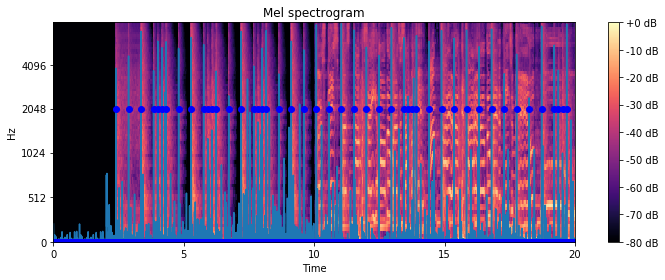

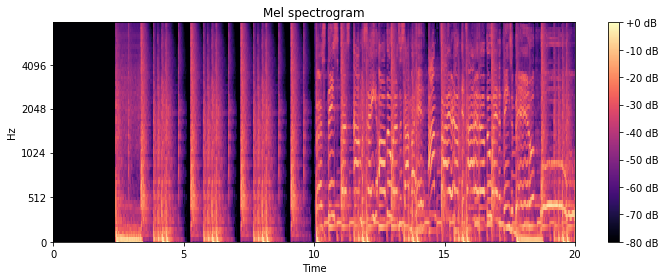

In [27]:
logger = logging.getLogger()
logger.setLevel(logging.WARN)
test2_key = "1fef"
dif_val = 4 # Expert value

plot_predict(song_df, test2_key, dif_val, spec_win_len, num_mels, rounding_win_len, 20)